# Cycle Analysis

## The Problem

Identify how the cycling habits of casual riders and those with annual memberships differ.

This analysis will focus on the following factors:
* The number of casual riders vs annual riders.
* The length of ride between the two groups.
* Which days of the week and months do either group prefer.
* Which routes get the most traffic.
* Which routes do either group prefer.

## The Data

The data for this case study comes from Divvy, a bike share service in Chicago that this example is based off of. The data can be downloaded [here](https://divvy-tripdata.s3.amazonaws.com/index.html).

Divvy provides monthly trip data on how their bikes are used under a [license](https://ride.divvybikes.com/data-license-agreement) which allows analysis to be performed.

The data does not contain any private information about the customers using the service. Every ride is given a `ride_id`, a random 16-character long alpha-numeric string which acts as a unique identifier of the trip taken. It is not believed that anything related to the user is contained inside this data.

This data is believed to be credible and complete, however since it comes from another commercial entity it is possible that there is more information that they are not providing. It is also possible that some information has been obfuscated, possibly to protect user identification.

The data contains the following biases:
* It contains information for only one ride share company.
* It contains information for a single city (Chicago).
* We are limiting our analysis to a 12 months period (2023-03 to 2022-04).

## Preparing the Data

### Tools Used

Analysis for this project will be done in Python. Python has a wide verity of tools for performing analysis and creating visualizations.

To perform our analysis, we will need the following packages.

In [231]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from matplotlib import pyplot as plt
from pathlib import Path
from datetime import datetime
from datetime import timedelta

### Assembling Data

As mentioned previously, analysis will be done on the past 12-months of trip data. This data is contained within the following files:

In [3]:
for file in Path.iterdir(Path(r"data")):
    print(file.name)

202204-divvy-tripdata.csv
202205-divvy-tripdata.csv
202206-divvy-tripdata.csv
202207-divvy-tripdata.csv
202208-divvy-tripdata.csv
202209-divvy-tripdata.csv
202210-divvy-tripdata.csv
202211-divvy-tripdata.csv
202212-divvy-tripdata.csv
202301-divvy-tripdata.csv
202302-divvy-tripdata.csv
202303-divvy-tripdata.csv


To do our analysis we will need to combine each of these `csv` files into a single dataframe. We will do this using `Pandas`.

In [4]:
frames = [pd.read_csv(str(file)) for file in Path.iterdir(Path(r"data"))]
df = pd.concat(frames)
print(f"There are {df.shape[0]} entires in the combined data")
df.head()

There are 5803720 entires in the combined data


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,3564070EEFD12711,electric_bike,2022-04-06 17:42:48,2022-04-06 17:54:36,Paulina St & Howard St,515,University Library (NU),605,42.019135,-87.673532,42.052939,-87.673447,member
1,0B820C7FCF22F489,classic_bike,2022-04-24 19:23:07,2022-04-24 19:43:17,Wentworth Ave & Cermak Rd,13075,Green St & Madison St,TA1307000120,41.853085,-87.631931,41.881892,-87.648789,member
2,89EEEE32293F07FF,classic_bike,2022-04-20 19:29:08,2022-04-20 19:35:16,Halsted St & Polk St,TA1307000121,Green St & Madison St,TA1307000120,41.871840,-87.646640,41.881892,-87.648789,member
3,84D4751AEB31888D,classic_bike,2022-04-22 21:14:06,2022-04-22 21:23:29,Wentworth Ave & Cermak Rd,13075,Delano Ct & Roosevelt Rd,KA1706005007,41.853085,-87.631931,41.867491,-87.632190,casual
4,5664BCF0D1DE7A8B,electric_bike,2022-04-16 15:56:30,2022-04-16 16:02:11,Halsted St & Polk St,TA1307000121,Clinton St & Madison St,TA1305000032,41.871808,-87.646574,41.882242,-87.641066,member


### Cleaning & Calculating Data

The data will be checked in the following ways:
* Identifying if any rows contain `null` values.
* Removing any rows where `started_at` is older than `ended_at`.
* Calculating the `ride_duration` and `ride_duration_minutes` columns.
* Removing any rows where the `ride_duration_minutes` is an outlier.
* Calculating `month` and `day_of_week` columns.

#### Checking for Rows with Null Values

Each column is checked for `null` values in the following ways.

In [6]:
for col in df.columns:
    if pd.isna(df[col]).any():
        print(f"Column '{col}' contains null values")
print(f"{df.isna().sum().sum()} rows contain null values")

Column 'start_station_name' contains null values
Column 'start_station_id' contains null values
Column 'end_station_name' contains null values
Column 'end_station_id' contains null values
Column 'end_lat' contains null values
Column 'end_lng' contains null values
3482785 rows contain null values


There are an extensive number of rows with `null` values. It also appears that the columns that do contain `null` values only occur in columns that are related to where the ride started from and ended at.

Based on this, we will accept these null values for the bulk of our analysis but will address this later when analyzing trips.

#### Removing Entries with Erroneous Start & End Times

Before we can begin, we need to properly convert the `started_at` and `ended_at` columns to `datetime` objects.

In [7]:
df['started_at'] = pd.to_datetime(df['started_at'], format="%Y-%m-%d %H:%M:%S")
df['ended_at'] = pd.to_datetime(df['ended_at'], format="%Y-%m-%d %H:%M:%S")

With the format of those columns changed, we can properly identify if there are any errors with our start and end times.

In [8]:
print(f"{df.query('started_at >= ended_at').shape[0]} erroneous time entries")

539 erroneous time entries


Several erroneous entries were found. Since we do not have enough information on what caused them and how to resolve them, so instead we will remove them.

In [9]:
df = df[df['started_at'] < df['ended_at']]
print(f"{df.shape[0]} entries remain in the dataframe")

5803181 entries remain in the dataframe


#### Calculating Ride Duration

Now with the data cleaned, we can calculate the `ride_duration` and `ride_duration_minutes` values.

In [10]:
_df = df.assign(ride_duration=df['ended_at']-df['started_at'])
df = _df
_df = df.assign(ride_duration_minutes=df['ride_duration'].apply(lambda x: x.total_seconds()/60))
df = _df

#### Calculating Month and Day of Week

The `day_of_week` column is created using the following method:

In [11]:
df['day_of_week'] = df['started_at'].apply(lambda x: x.strftime("%a"))
day_categories = [
    "Mon",
    "Tue",
    "Wed",
    "Thu",
    "Fri",
    "Sat",
    "Sun"
]
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_categories)

The `month` column is created using the following method:

In [12]:
df['month'] = df['started_at'].apply(lambda x: x.strftime("%B"))
month_categories = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December"
]
df["month"] = pd.Categorical(df['month'], categories=month_categories)

#### Removing Outlying Ride Duration

We will start by doing some basic statistical analysis on our data

In [13]:
ride_duration_minutes = np.array(df['ride_duration_minutes'])
print(f"Mean: {ride_duration_minutes.mean():.2f}")
print(f"Standard Deviation: {ride_duration_minutes.std():.2f}")
print(f"Max: {ride_duration_minutes.max():.2f}")
print(f"Min: {ride_duration_minutes.min():.2f}")
print(f"Median: {np.median(ride_duration_minutes):.2f}")
print(f"First Quartile: {np.quantile(ride_duration_minutes, 0.25):.2f}")
print(f"Third Quartile: {np.quantile(ride_duration_minutes, 0.75):.2f}")

Mean: 18.98
Standard Deviation: 173.71
Max: 41387.25
Min: 0.02
Median: 10.03
First Quartile: 5.68
Third Quartile: 18.02


There seems to be a large number of outliers in the `ride_duration`, there are some entries that indicate that a bike was being rented for almost a month.

We will create a new dataframe with all outlying entries removed.

In [14]:
q1 = np.quantile(ride_duration_minutes, 0.25)
q3 = np.quantile(ride_duration_minutes, 0.75)
iqr = q3-q1
lower_limit = q1-(1.5*iqr)
upper_limit = q3+(1.5*iqr)

ride_duration_df = df.query("ride_duration_minutes > @lower_limit and ride_duration_minutes < @upper_limit")
print(f"{ride_duration_df.shape[0]} entries exist in this new dataframe")

5374272 entries exist in this new dataframe


### Finding Ride Locations

The start and end locations for each ride is recorded, and while latitude and longitude information is very informative, it can be hard to conceptualize in a meaningful way.

To be able to meaningfully determine what areas of Chicago riders frequent, required that we translate the latitudinal and longitudinal information into neighborhoods and group the data that way.

To do this, `GeoPandas` will be used. This is an extension of the Python library `Pandas` that offers additional functionality for working with geospatial data and **Shapefiles**.

> The shapefile format is a geospatial vector data format for geographic information system (GIS) software. It is developed and regulated by Esri as a mostly open specification for data interoperability among Esri and other GIS software products.[1] The shapefile format can spatially describe vector features: points, lines, and polygons, representing, for example, water wells, rivers, and lakes. Each item usually has attributes that describe it, such as name or temperature.

https://en.wikipedia.org/wiki/Shapefile

The Shapefiles for Chicago's neighborhoods were obtained from the Chicago Data Portal
https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Neighborhoods/bbvz-uum9

These files were downloaded and opened as it's own GeoPandas dataframe

In [224]:
neighborhood_df = gpd.read_file(r"shapefiles/chicago_neighborhoods/geo_export_ca0257d5-43ba-4516-ba7c-432013f65dd7.shp")
neighborhood_df.head()

,pri_neigh,sec_neigh,shape_area,shape_len,geometry
0,Grand Boulevard,BRONZEVILLE,4.849250e+07,28196.837157,"POLYGON ((-87.60671 41.81681, -87.60670 41.816..."
1,Printers Row,PRINTERS ROW,2.162138e+06,6864.247156,"POLYGON ((-87.62761 41.87437, -87.62760 41.873..."
2,United Center,UNITED CENTER,3.252051e+07,23101.363745,"POLYGON ((-87.66707 41.88885, -87.66707 41.888..."
3,Sheffield & DePaul,SHEFFIELD & DEPAUL,1.048259e+07,13227.049745,"POLYGON ((-87.65833 41.92166, -87.65835 41.922..."
4,Humboldt Park,HUMBOLDT PARK,1.250104e+08,46126.751351,"POLYGON ((-87.74060 41.88782, -87.74060 41.887..."


The two columns of the dataframe that are of interest are `pri_neigh` and `geometry`:
* `pri_neigh` is the name of the primary neighborhood and what will be used to name the location of each ride.
* `geometry` is a `Polygon``, a collection of points which describe the bounds of each neighborhood and how to draw it.

With the neighborhood data obtained, the next step was create a GeoDataFrame from our main Dataframe

In [225]:
geo_df = gpd.GeoDataFrame(data=df)

Next, `Points` need to be created from the starting longitude and latitude data and assigned as `geometry` for the dataframe. The coordinate system for our dataframe is set to the coordinate system of the neighborhood dataframe.

In [226]:
geo_df['start_point'] = gpd.points_from_xy(geo_df['start_lng'], geo_df['start_lat'])
geo_df = geo_df.set_geometry('start_point')
geo_df.crs = neighborhood_df.crs
geo_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration,ride_duration_minutes,day_of_week,month,start_point,end_point
0,3564070EEFD12711,electric_bike,2022-04-06 17:42:48,2022-04-06 17:54:36,Paulina St & Howard St,515,University Library (NU),605,42.019135,-87.673532,42.052939,-87.673447,member,0 days 00:11:48,11.800000,Wed,April,POINT (-87.67353 42.01913),POINT (-87.67345 42.05294)
1,0B820C7FCF22F489,classic_bike,2022-04-24 19:23:07,2022-04-24 19:43:17,Wentworth Ave & Cermak Rd,13075,Green St & Madison St,TA1307000120,41.853085,-87.631931,41.881892,-87.648789,member,0 days 00:20:10,20.166667,Sun,April,POINT (-87.63193 41.85308),POINT (-87.64879 41.88189)
2,89EEEE32293F07FF,classic_bike,2022-04-20 19:29:08,2022-04-20 19:35:16,Halsted St & Polk St,TA1307000121,Green St & Madison St,TA1307000120,41.871840,-87.646640,41.881892,-87.648789,member,0 days 00:06:08,6.133333,Wed,April,POINT (-87.64664 41.87184),POINT (-87.64879 41.88189)
3,84D4751AEB31888D,classic_bike,2022-04-22 21:14:06,2022-04-22 21:23:29,Wentworth Ave & Cermak Rd,13075,Delano Ct & Roosevelt Rd,KA1706005007,41.853085,-87.631931,41.867491,-87.632190,casual,0 days 00:09:23,9.383333,Fri,April,POINT (-87.63193 41.85308),POINT (-87.63219 41.86749)
4,5664BCF0D1DE7A8B,electric_bike,2022-04-16 15:56:30,2022-04-16 16:02:11,Halsted St & Polk St,TA1307000121,Clinton St & Madison St,TA1305000032,41.871808,-87.646574,41.882242,-87.641066,member,0 days 00:05:41,5.683333,Sat,April,POINT (-87.64657 41.87181),POINT (-87.64107 41.88224)


The dataframe needs a geometry and a coordinate system can be joined our data together.

In [227]:

geo_df = geo_df.sjoin(neighborhood_df, how="left", predicate="within")
geo_df.head()


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,ride_duration_minutes,day_of_week,month,start_point,end_point,index_right,pri_neigh,sec_neigh,shape_area,shape_len
0,3564070EEFD12711,electric_bike,2022-04-06 17:42:48,2022-04-06 17:54:36,Paulina St & Howard St,515,University Library (NU),605,42.019135,-87.673532,...,11.800000,Wed,April,POINT (-87.67353 42.01913),POINT (-87.67345 42.05294),48.0,Rogers Park,ROGERS PARK,5.125990e+07,34052.397576
1,0B820C7FCF22F489,classic_bike,2022-04-24 19:23:07,2022-04-24 19:43:17,Wentworth Ave & Cermak Rd,13075,Green St & Madison St,TA1307000120,41.853085,-87.631931,...,20.166667,Sun,April,POINT (-87.63193 41.85308),POINT (-87.64879 41.88189),68.0,Chinatown,"ARMOUR SQUARE,CHINATOWN",1.062473e+07,14452.766257
2,89EEEE32293F07FF,classic_bike,2022-04-20 19:29:08,2022-04-20 19:35:16,Halsted St & Polk St,TA1307000121,Green St & Madison St,TA1307000120,41.871840,-87.646640,...,6.133333,Wed,April,POINT (-87.64664 41.87184),POINT (-87.64879 41.88189),46.0,"Little Italy, UIC","LITTLE ITALY, UIC",7.137624e+07,36568.464289
3,84D4751AEB31888D,classic_bike,2022-04-22 21:14:06,2022-04-22 21:23:29,Wentworth Ave & Cermak Rd,13075,Delano Ct & Roosevelt Rd,KA1706005007,41.853085,-87.631931,...,9.383333,Fri,April,POINT (-87.63193 41.85308),POINT (-87.63219 41.86749),68.0,Chinatown,"ARMOUR SQUARE,CHINATOWN",1.062473e+07,14452.766257
4,5664BCF0D1DE7A8B,electric_bike,2022-04-16 15:56:30,2022-04-16 16:02:11,Halsted St & Polk St,TA1307000121,Clinton St & Madison St,TA1305000032,41.871808,-87.646574,...,5.683333,Sat,April,POINT (-87.64657 41.87181),POINT (-87.64107 41.88224),46.0,"Little Italy, UIC","LITTLE ITALY, UIC",7.137624e+07,36568.464289


The next step is to count the number of rides that start in each neighborhood. To do this an intermediate dataframe will be created.

In [228]:
neighborhoods = []
ride_count = []
geo_df_neighborhoods = set(geo_df['pri_neigh'])
values = geo_df['pri_neigh'].value_counts()
for neighborhood in neighborhood_df['pri_neigh']:
    if neighborhood in geo_df_neighborhoods:
        neighborhoods.append(neighborhood)
        ride_count.append(values[neighborhood])
ride_count_df = pd.DataFrame(
    data=zip(neighborhoods, ride_count),
    columns=['pri_neigh', 'ride_count']
)
ride_count_df = gpd.GeoDataFrame(ride_count_df)
ride_count_df

,pri_neigh,ride_count
0,Grand Boulevard,10233
1,Printers Row,31206
2,United Center,21822
3,Sheffield & DePaul,128070
4,Humboldt Park,49958
...,...,...
91,Belmont Cragin,19407
92,Austin,10057
93,Gold Coast,102887
94,Boystown,84553


With the intermediate dataframe created, it will then be merged to the dataframe containing the neighborhoods and the geometries for drawing the neighborhoods.

In [229]:
neighborhood_df = pd.merge(neighborhood_df, ride_count_df, how='left', on='pri_neigh')
neighborhood_df.head()

,pri_neigh,sec_neigh,shape_area,shape_len,geometry,ride_count
0,Grand Boulevard,BRONZEVILLE,4.849250e+07,28196.837157,"POLYGON ((-87.60671 41.81681, -87.60670 41.816...",10233.0
1,Printers Row,PRINTERS ROW,2.162138e+06,6864.247156,"POLYGON ((-87.62761 41.87437, -87.62760 41.873...",31206.0
2,United Center,UNITED CENTER,3.252051e+07,23101.363745,"POLYGON ((-87.66707 41.88885, -87.66707 41.888...",21822.0
3,Sheffield & DePaul,SHEFFIELD & DEPAUL,1.048259e+07,13227.049745,"POLYGON ((-87.65833 41.92166, -87.65835 41.922...",128070.0
4,Humboldt Park,HUMBOLDT PARK,1.250104e+08,46126.751351,"POLYGON ((-87.74060 41.88782, -87.74060 41.887...",49958.0


With the ride count merged with our geometry dataframe, the map showing the number of rides starting at each neighborhood can be drawn.

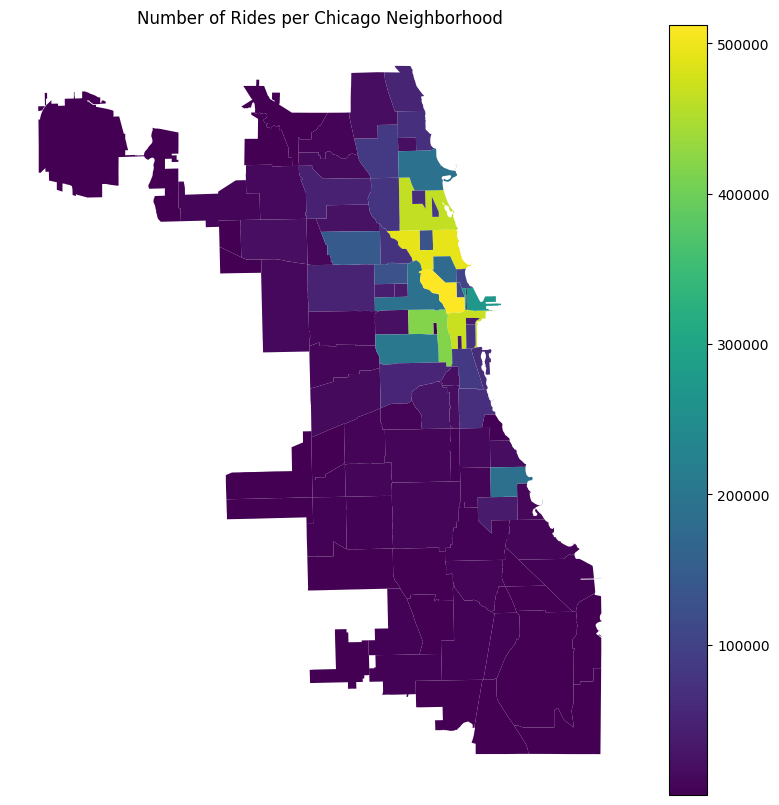

In [230]:
fig, ax = plt.subplots(figsize=(10,10))
neighborhood_df.plot(column="ride_count", legend=True, ax=ax)
plt.title("Number of Rides per Chicago Neighborhood")
plt.axis('off')
plt.show()

## Analysis

### Annual Members vs Casual Riders

The first analysis that will be performed will be showing the breakdown of annual members vs casual riders.

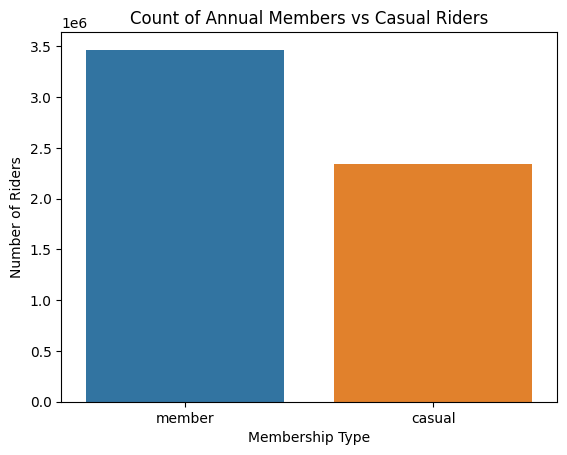

In [121]:
sns.countplot(
    data=df,
    x="member_casual"
).set(
    title="Count of Annual Members vs Casual Riders",
    xlabel="Membership Type",
    ylabel="Number of Riders"
)
plt.show()

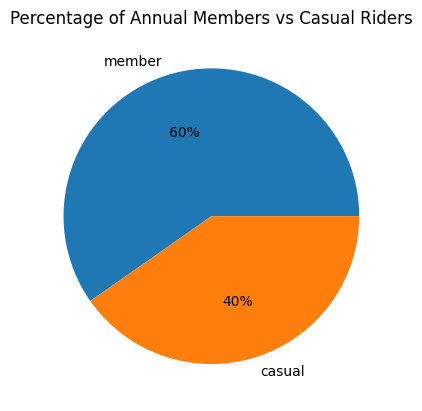

In [122]:
member_count = df['member_casual'].value_counts()['member']
casual_count = df['member_casual'].value_counts()['casual']

plt.pie(
    x=[member_count, casual_count],
    labels=['member', 'casual'],
    autopct="%.0f%%",
)
plt.title("Percentage of Annual Members vs Casual Riders")
plt.show()

Currently there are more annual members than casual riders.

### Riders each Month

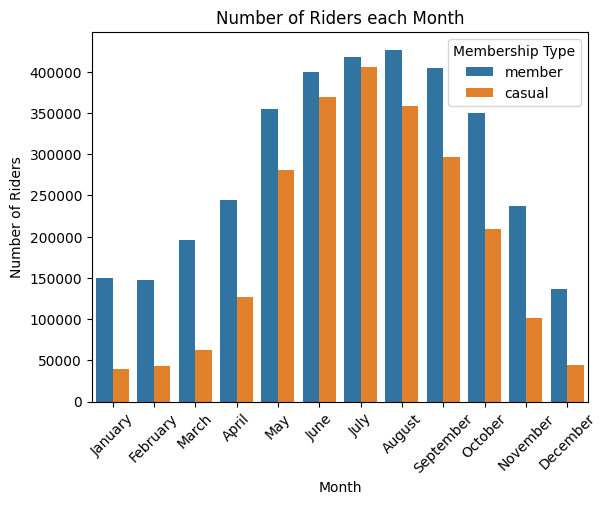

In [123]:
sns.countplot(
    data=df,
    x="month",
    hue="member_casual"
).set(
    title="Number of Riders each Month",
    xlabel="Month",
    ylabel="Number of Riders"
    )
plt.legend(title="Membership Type")
plt.xticks(rotation=45)
plt.show()

As is expected, the summer months of June, July and August have the highest number of riders and the winters months of December, January and February have the lowest.

What is interesting is that casual ridership increases to almost the same levels as those with annual membership during the summer months. Annual members are also far more likely (over three times) to ride in the winter than casual riders.

### Riders Each Day

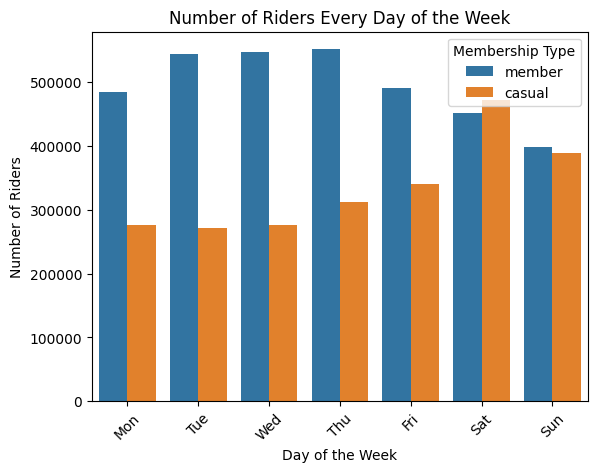

In [124]:
sns.countplot(
    data=df,
    x="day_of_week",
    hue="member_casual"
).set(
    title="Number of Riders Every Day of the Week",
    xlabel="Day of the Week",
    ylabel="Number of Riders"
    )
plt.legend(title="Membership Type")
plt.xticks(rotation=45)
plt.show()

Annual members are more often to ride during the weekdays while casual riders are more likely to ride during the weekend.

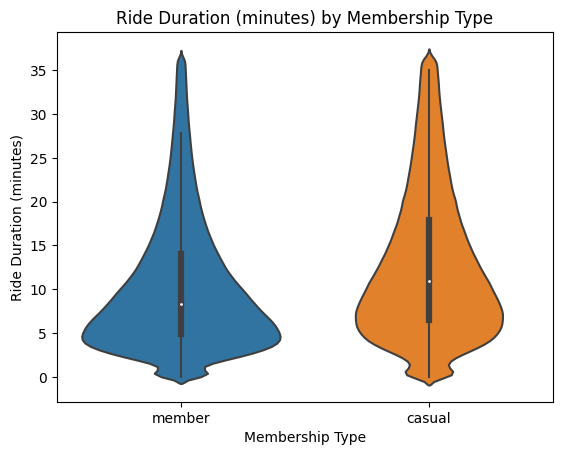

In [125]:
sns.violinplot(
    data=ride_duration_df,
    x="member_casual",
    y="ride_duration_minutes"
).set(
    title="Ride Duration (minutes) by Membership Type",
    xlabel="Membership Type",
    ylabel="Ride Duration (minutes)"
)
plt.show()

Annual members are more likely to take shorter rides than casual riders.

### Electric Bike vs Regular Bike

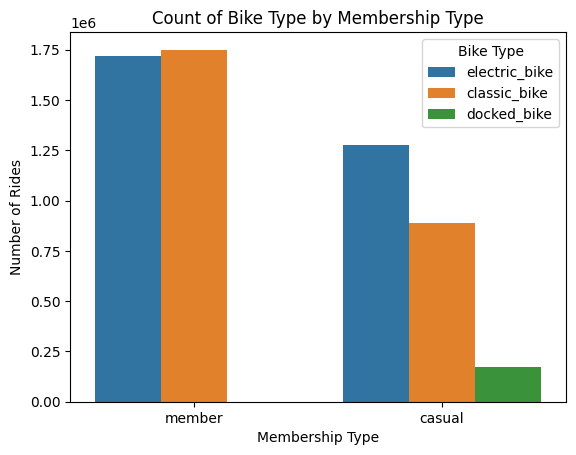

In [126]:
sns.countplot(
    data=df,
    x="member_casual",
    hue="rideable_type"
).set(
    title="Count of Bike Type by Membership Type",
    xlabel="Membership Type",
    ylabel="Number of Rides"
)
plt.legend(title="Bike Type")
plt.show()

Casual members slightly prefer classic bikes than electric bikes, while casual riders prefer electric bikes. Casual riders are also the only ones who use docked bikes.

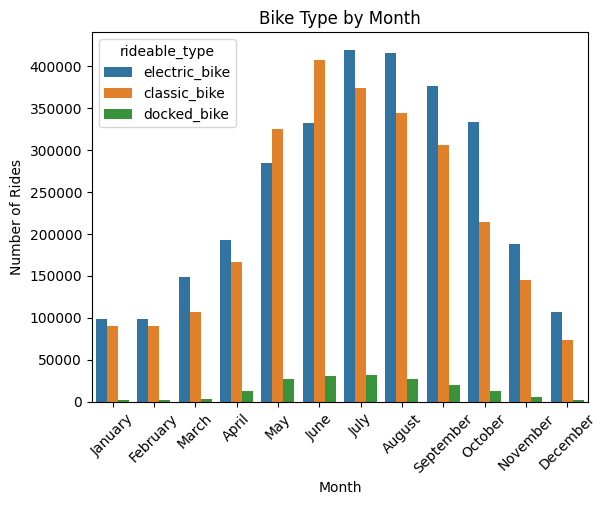

In [127]:
sns.countplot(
    data=df,
    x="month",
    hue="rideable_type"
).set(
    title="Bike Type by Month",
    xlabel="Month",
    ylabel="Number of Rides"
)
plt.xticks(rotation=45)
plt.show()

Electric bikes are preferred most months, except in May and June were classic bikes were ridden more. This change coincides with the uptake of casual riders during those months and could be related.

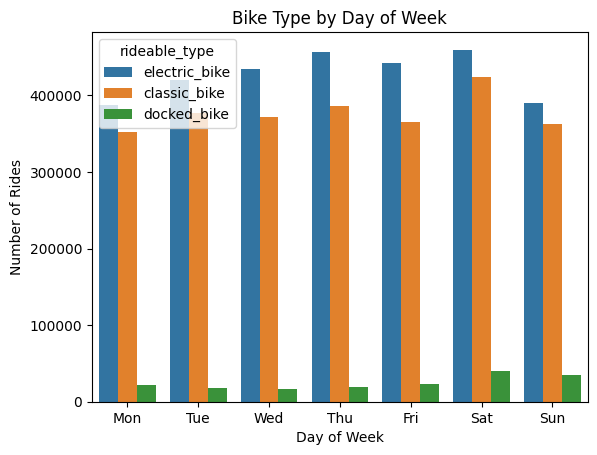

In [128]:
sns.countplot(
    data=df,
    x="day_of_week",
    hue="rideable_type"
).set(
    title="Bike Type by Day of Week",
    xlabel="Day of Week",
    ylabel="Number of Rides"
)
plt.show()

The preference of bike type does not appear to change much from day to day.